# Принятие решений в бизнесе

# Описание проекта
<a id='0'></a>

Отделом маркетинга крупного интернет-магазина был подготовлен список гипотез для увеличения выручки.
Нам необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Цель исследования** - выяснить, какая из гипотез приведет к наибольшему увеличению выручки, проанализировать результаты A/B-теста, принять решение по результатам.

В нашем распоряжении файл **hypothesis** с 9 гепотезами, файл **orders** с выручкой, файл **visitors** с информацией о количестве посетителей по дням в каждой группе.

О качестве данных ничего не известно. Проверим данные на ошибки и оценим их влияние на исследование. 
Затем, на этапе предобработки поищем возможность исправить самые критичные ошибки данных.

Таким образом, исследование пройдёт в несколько этапов:

- Предобработка данных.
- Приоритизация гипотез.
- Анализ A/B-теста, принятие решения по результатам теста.

# Описание данных

#### Данные для первой части

Файл hypothesis.csv

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Данные для второй части

Файл orders.csv

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

Загрузим данные, подготовим данные к анализу.

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st 

In [2]:
pd.set_option("max_colwidth", 200)

#прочитаем файлы и сохраним их в отдельные датафреймы
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv', sep=','),
    pd.read_csv('/datasets/visitors.csv', sep=','),
)

#посмотрим датафрейм hypothesis
hypothesis.head(2)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10


In [3]:
#приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [4]:
#посмотрим первые 5 строк датафрейма orders
orders.head() 

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.sort_values(by='revenue', ascending=False).head(5)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B


In [6]:
#посмотрим первые 5 строк датафрейма visitors
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
#посмотрим общую информацию
print(visitors.info()) 
print('- - - - - - -')
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
- - - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


В обоих датфреймах столбец date в формате object, переведем в datetime с помощью lambda-функции методом map()

In [8]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [10]:
#посчитаем явные дубликаты
orders.duplicated().sum(), visitors.duplicated().sum()

(0, 0)

### Вывод
<a id='1.1'></a>
Мы подготовили данные для дальнейшего анализа:
- прочитали, сохранили в отдельные датафреймы,
- преобразовали данные о времени в нужный формат,
- проверили на наличие явных дубликатов.

[Назад к оглавлению](#0)

## Часть 1. Приоритизация гипотез.


**Таблица hypothesis** 

* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/hypothesis.csv. [Скачать датасет](https://code.s3.yandex.net/datasets/hypothesis.csv)

В файле hypothesis 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
Применим фреймворки ICE и RICE и посмотрим различия.

In [11]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### 1.1. Приоритизации гипотез  при помощи фреймворка ICE

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [12]:
hypothesis['ICE'] =round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 1)

display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Гипотезы по фремворку ICE расположились так: 8 -> 0 -> 7 -> 6 -> 2 по убыванию значимости.

### 1.2. Приоритизации гипотез  при помощи фреймворка RICE

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [13]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Гипотезы по фремворку RICE расположились так: 7 -> 2 -> 0 -> 6 -> 8 по убыванию значимости.

### 1.3. Различие. Вывод

Фреймворк RICE учитывает критерий охвата, поэтому логично отсортировать сначала по RICE, затем по ICE.

In [14]:
hypothesis[['ICE', 'hypothesis', 'RICE']]. sort_values(by=['RICE', 'ICE'], ascending=False).head(5)

,ICE,hypothesis,RICE
7,11.2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,7.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,13.3,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,8.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,16.2,"Запустить акцию, дающую скидку на товар в день рождения",16.2


При использовании ICE вышла в лидеры гипотеза "Запустить акцию, дающую скидку на товар в день рождения", но ICE не учитывает охват, поэтому при использовании RICE стало более наглядно, что делать выбор стоит в пользу вариантов, которые в потенциале увеличат выручку. 

Цифры цифрами, но здравый смысл подсказывает, что опираться на день рождения как главный источник увеличения выручки менее эффективно, чем использовать форму подписки для e-mail рассылок. 

В лидеры вышли гипотезы под номерами 7, 2, 0. И держать в запасе еще 2 гипотезы: 6 и 8.

[Назад к оглавлению](#0)

## Часть 2. Анализ A/B-теста

После проведенного A/B-теста были получены результаты, которые описаны в orders и visitors. Нам необходимо проанализировать результаты.
- Построем график кумулятивной выручки по группам. 
- Построем график кумулятивного среднего чека по группам. 
- Построем график относительного изменения кумулятивного среднего чека группы B к группе A. 
- Построем график кумулятивной конверсии по группам. 
- Построем график относительного изменения кумулятивной конверсии группы B к группе A. 
- Построем точечный график количества заказов по пользователям. 
- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.
- Построем точечный график стоимостей заказов.
- Посчитаем 95-й и 99-й перцентили стоимости заказов. .
- Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
- Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

#### Описание данных 

**Таблица orders**

* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

**Таблица visitors**

* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

### Подготовка данных для анализа А/В теста

In [15]:
#выдедем первые 5 строк 
display(orders.head(), visitors.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [16]:
#посчитаем количество заказов в каждой группе
print(orders.query('group=="A"').shape[0])
print(orders.query('group=="B"').shape[0])

557
640


In [17]:
#проверим, есть ли уникальные посетители, которые вошли в обе группы
group_A = orders.query('group=="A"')[['group','visitorId']]
group_B = orders.query('group=="B"')[['group','visitorId']]

duplicated_visitors = pd.merge(group_A, group_B, on = 'visitorId', how ='inner')
duplicated_visitors = duplicated_visitors['visitorId'].unique()
orders = orders.query('visitorId not in (@duplicated_visitors)')

len(duplicated_visitors)

58

Получается, что 58 уникальных покупателей вошли в обе группы.

In [18]:
#посчитаем количество заказов в каждой группе
print(orders.query('group=="A"').shape[0])
print(orders.query('group=="B"').shape[0])

468
548


In [19]:
#посчитаем количество пользователей в каждой группе
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [20]:
# количество пользователей в день в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество пользователей в день в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

display(visitorsADaily.head(), visitorsBDaily.head())

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [21]:
visitorsADaily.visitorsPerDateA.sum(), visitorsBDaily.visitorsPerDateB.sum()

(18736, 18916)

Количество посещений в группах за месяц проведения теста практически совпадает.

In [22]:
# накопительное количество пользователей в день в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# накопительное количество пользователей в день в группе B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

display(visitorsACummulative.head(), visitorsBCummulative.head())

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [23]:
#количество заказов и суммарная выручка в день по группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#количество заказов и суммарная выручка в день по группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']


display(ordersADaily.head(), ordersBDaily.head())

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [24]:
# накопительное количество заказов и суммарной выручки в день по группе А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# накопительное количество заказов и суммарной выручки в день по группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

display(ordersACummulative.tail(), ordersBCummulative.tail())

,date,ordersCummulativeA,revenueCummulativeA
26,2019-08-27,419,2940471
27,2019-08-28,434,3036933
28,2019-08-29,451,3233233
29,2019-08-30,460,3311413
30,2019-08-31,468,3364656


,date,ordersCummulativeB,revenueCummulativeB
26,2019-08-27,473,4579312
27,2019-08-28,495,4640510
28,2019-08-29,510,4746610
29,2019-08-30,531,4955833
30,2019-08-31,548,5068972


Количество заказов в группе A меньше (468), чем в группе B (548). 

In [25]:
# объединим полученные данные в один датасет, по дате заказа
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


### 2.1. График кумулятивной выручки по группам. 


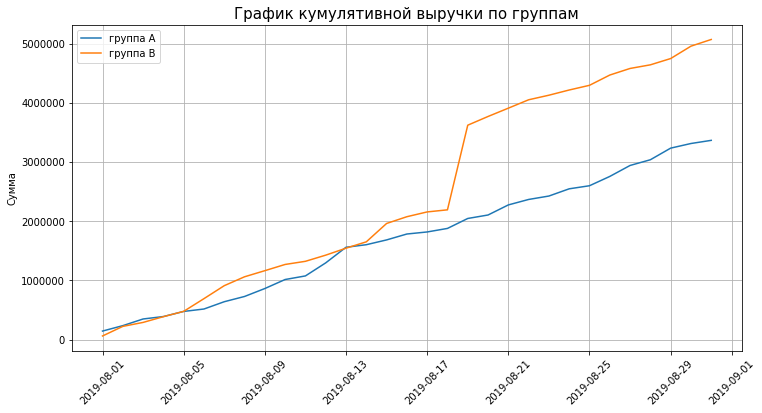

In [26]:
import warnings
warnings.filterwarnings("ignore")

#зададим размер
plt.figure(figsize=(12, 6))
plt.grid()

# график кумулятивной выручки группы А
plt.plot(data['date'], data['revenueCummulativeA'], label='группа A')

# график кумулятивной выручки группы B
plt.plot(data['date'], data['revenueCummulativeB'], label='группа B')
plt.xticks(rotation=45)
plt.title('График кумулятивной выручки по группам', fontsize=15)
plt.ylabel('Сумма')
plt.legend()

plt.ticklabel_format(style='plain', axis='y')

### Выводы и предположения.

Выручка по обеим группам устойчиво растет в течение всего теста.
В группе В есть хорошо заметный скачок говорящий о том что в данных есть выбросы в районе 18-20 августа. 

[Назад к оглавлению](#0)

### 2.2. График кумулятивного среднего чека по группам. 

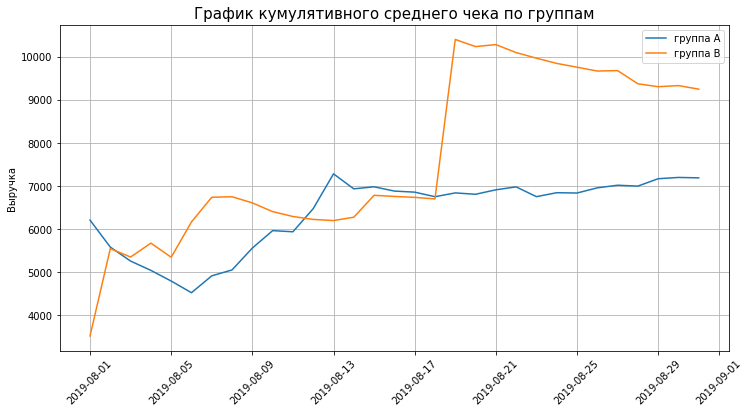

In [27]:
#зададим размер и заголовок
plt.figure(figsize=(12, 6))
plt.title('График кумулятивного среднего чека по группам', fontsize=15)

# график кумулятивного среднего чека группы А
plt.plot(data['date'], data['revenueCummulativeA'] / data['ordersCummulativeA'], label='группа A')

# график кумулятивного среднего чека группы B
plt.plot(data['date'], data['revenueCummulativeB'] / data['ordersCummulativeB'], label='группа B')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

### Выводы и предположения.

Средний чек обеих групп выравнивается после 13.08. Однако, в очередной раз видим, что по группе В есть крупная покупка после 17.08 и после неё чек этой группы начинает снижаться.

[Назад к оглавлению](#0)

### 2.3. График относительного изменения кумулятивного среднего чека группы B к группе A. 

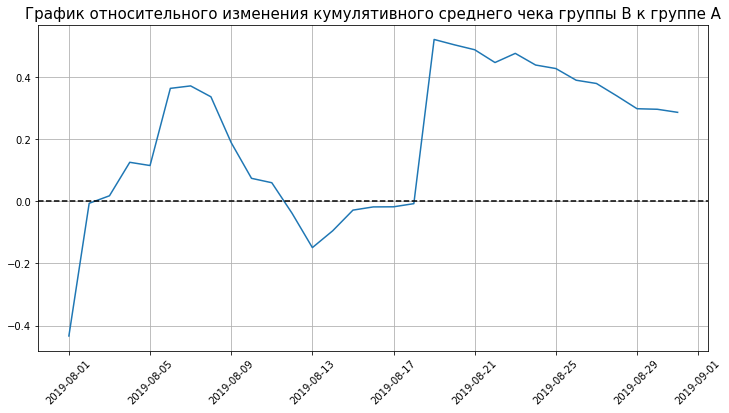

In [28]:
#зададим размер и заголовок
plt.figure(figsize=(12, 6))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=15);

plt.plot(data['date'], (data['revenueCummulativeB']/data['ordersCummulativeB'])/(
                        data['revenueCummulativeA']/data['ordersCummulativeA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.grid()

### Выводы и предположения.

Очередное подтверждение того, что где-то прячутся крупные заказы.

[Назад к оглавлению](#0)

### 2.4. График кумулятивной конверсии по группам. 

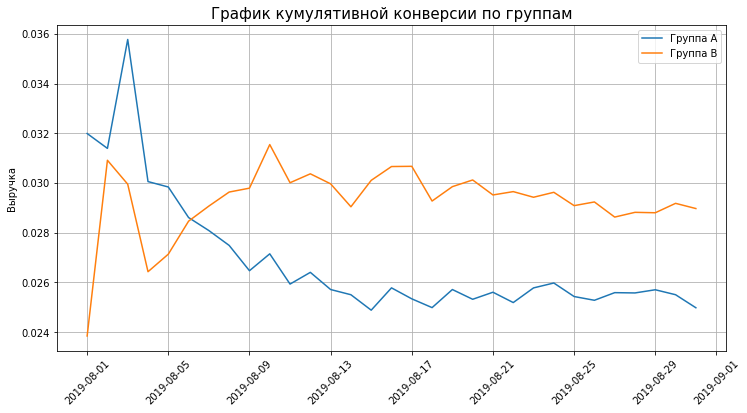

In [29]:
#зададим размер и заголовок
plt.figure(figsize=(12, 6))
plt.title('График кумулятивной конверсии по группам', fontsize=15)
plt.ylabel("Выручка")

# строим график кумулятивной конверсии
plt.plot(data['date'], data['ordersCummulativeA'] / data['visitorsCummulativeA'], label='Группа A')
plt.plot(data['date'], data['ordersCummulativeB'] / data['visitorsCummulativeB'], label='Группа B')

plt.xticks(rotation=45)
plt.legend()
plt.grid();


### Выводы и предположения.

Первые дни конверсия в обеих группах "прыгала", но потом выровнялась, и по графику видно, что группа В лидирет.

[Назад к оглавлению](#0)

### 2.5. График относительного изменения кумулятивной конверсии группы B к группе A. 

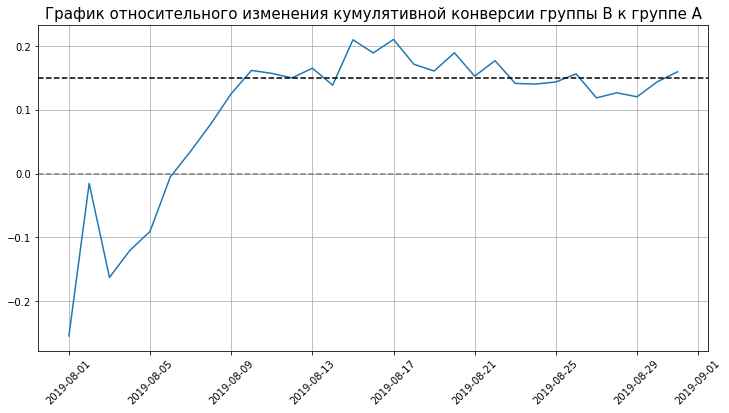

In [30]:
#зададим размер и заголовок
plt.figure(figsize=(12, 6))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=15)

plt.plot(data['date'], (data['ordersCummulativeB'] / data['visitorsCummulativeB']) / (
                        data['ordersCummulativeA'] / data['visitorsCummulativeA'])-1)

plt.xticks(rotation=45)
plt.grid()
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=0.15, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

### Выводы и предположения.

Группа B брала разгон в начале теста, после стабильно и существенно обгоняет группу А, в последней трети эксперимента наблюдается стабилизация результатов.

[Назад к оглавлению](#0)

### 2.6. Точечный график количества заказов по пользователям. 

In [31]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'transactionId']

ordersByUsers.sort_values(by='transactionId', ascending=False).head()

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


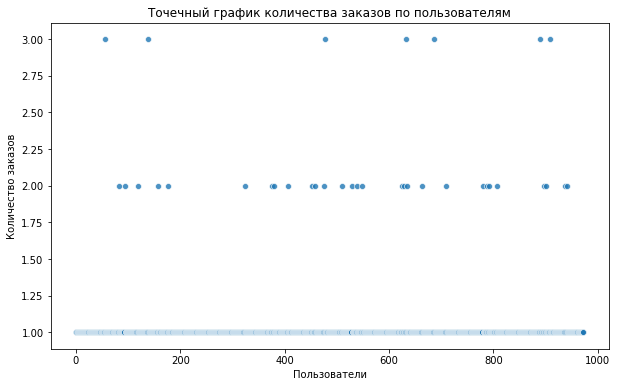

In [32]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(10, 6))
sns.scatterplot(x = x_values, y = ordersByUsers['transactionId'], alpha = 0.8)
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Пользователи')
plt.show()

### Выводы и предположения.

Больше 2 заказов у пользователя можно считать аномальным явлением, всего несколько пользователей заказывали более 6 раз.
Проверим показатели по выбросам с помощью 95-99% границ распределения.

[Назад к оглавлению](#0)

### 2.7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. 
Выберите границу для определения аномальных пользователей.

In [33]:
print(np.percentile(ordersByUsers['transactionId'], [95, 99]))

[1. 2.]


Не более 1% пользователей — больше 2-х заказов. Примем за верхнюю границу диапазона 1 заказ.

### 2.8. Точечный график стоимостей заказов. 

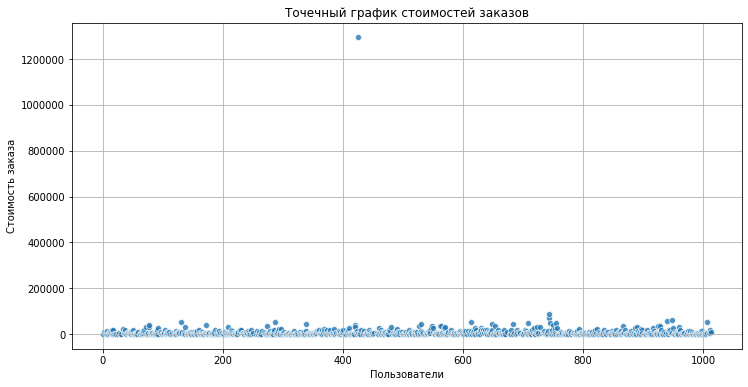

In [34]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(12, 6))
sns.scatterplot(x = x_values, y = orders['revenue'], alpha = 0.8)
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Пользователи')
plt.grid()
plt.ticklabel_format(style='plain', axis='y')

Заказов стоимостью 100 000 рублей не очень
много. Есть выбросы в районе 200 000 рублей и в районе 1 200 000 рублей. Заказ на 1.2 миллиона выглядит аномально.

Изменим масштаб и посмотрим в пределах 100 000

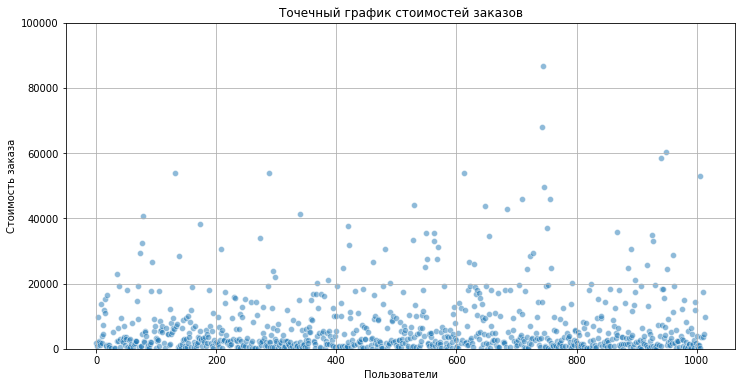

In [35]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12, 6))
sns.scatterplot(x = x_values, y = orders['revenue'], alpha = 0.5)
plt.ylim(0, 100000);
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Пользователи')
plt.grid()
plt.ticklabel_format(style='plain', axis='y')

### Выводы и предположения.

Заказы от 20000 до 30000 уже кажутся редкими, проверим при помощи перцентилей.

[Назад к оглавлению](#0)

### 2.9. Посчитайте 95-й и 99-й перцентили стоимости заказов. 

Выберите границу для определения аномальных заказов.

In [36]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более, чем у 5% заказов чек дороже 26 785 рублей. И не больше, чем у 1% заказов — дороже 53 904 рублей. Возьмем за верхнюю границу 27000, так мы охватим 95%.

### 2.10. Статистическая значимость различий в конверсии между группами по «сырым» данным. 

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'].
В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [37]:
# пользователи группы А
ordersByUsersA = orders[orders['group']=='A'] \
                        .groupby('visitorId', as_index=False) \
                        .agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'transactionId']

# пользователи группы В
ordersByUsersB = orders[orders['group']=='B'] \
                          .groupby('visitorId', as_index=False) \
                          .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'transactionId']

display(ordersByUsersA.head(), ordersByUsersB.head())

,visitorId,transactionId
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,visitorId,transactionId
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Для проведения статистического анализа по критерием Манна-Уитни создадим две переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [38]:
sampleA = pd.concat([ordersByUsersA['transactionId'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])),
                               name='transactionId',)], axis=0)

sampleB = pd.concat([ordersByUsersB['transactionId'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])),
                               name='transactionId')],axis=0)

In [39]:
sampleA.shape, sampleB.shape

((18736,), (18916,))

Для проверки значимости сформулируем нулевую и альтернативную гипотезы. 
- H0: Различие конверсий групп не является статистически значимой. 
- H1: Различие конверсий групп статистически значимо.

Возьмем уровень значимости 5%

In [40]:
alpha = 0.05
if (st.mannwhitneyu(sampleA, sampleB)[1] < alpha):
    print("Отвергаем нулевую гипотезу, \nстатистически значимые различия в конверсии групп А и В есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print("p-value = {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

Отвергаем нулевую гипотезу, 
статистически значимые различия в конверсии групп А и В есть
p-value = 0.006


Проверим насколько различаются конверсии в двух группах А и В.

In [41]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.160


Отношение конверсий групп В и А = 16%

### Выводы и предположения.

- Различия в конверсии групп А и В статистически значимые.
- Конверсия группы В на 16% выше, чем в группе А.

[Назад к оглавлению](#0)

### 2.11. Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Проверим гипотезы о различии показателей в среднем чеке в двух группах А и В. 

- H0: Cтатистически значимых различий в размере среднего чека нет.
- H1: Различие среднего чека статистически значимо

Возьмем уровень значимости 5%

In [42]:
alpha = 0.05
if (st.mannwhitneyu(
                orders[orders['group']=='A']['revenue'], 
                orders[orders['group']=='B']['revenue'])[1] < alpha):
    print("Отвергаем нулевую гипотезу, \nстатистически значимые различия в среднем чеке групп А и В есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, \nстатистически значимых различий в среднем чеке групп А и В нет")

print("p-value = {0:.3f}".format(st.mannwhitneyu(
                            orders[orders['group']=='A']['revenue'], 
                            orders[orders['group']=='B']['revenue'])[1]))

Не получилось отвергнуть нулевую гипотезу, 
статистически значимых различий в среднем чеке групп А и В нет
p-value = 0.415


Найдём относительные различия в среднем чеке между группами

In [43]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.287


Отношение среднего чека групп В и А = 28,7%

### Выводы и предположения.

- Статистически значимых различий в среднем чеке групп А и В нет.
- Средний чек группы В выше на 28,7% (в среднем) чем в группе А.

[Назад к оглавлению](#0)

### 2.12. Статистическая значимость различий в конверсии между группами по «очищенным» данным. 

In [44]:
# определяем базу по заказам с аномальным количеством

order_lim = np.percentile(ordersByUsers['transactionId'], 95)

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionId'] > order_lim]['visitorId'],
        ordersByUsersB[ordersByUsersB['transactionId'] > order_lim]['visitorId'],
    ],
    axis=0,
)

# определяем базу по аномальной сумме заказа
revenue_lim = np.percentile(orders['revenue'], 95)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']

# создаем список пользователей совершивших аномальные заказы
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print(abnormalUsers.shape)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64
(86,)


Пользователей с аномальными заказами - 86

In [45]:
# создаем базу для расчетов с отфильтрованными заказами для группы А
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'] \
                                   .isin(abnormalUsers))]['transactionId'], 
     pd.Series(0, index=np.arange(data['visitorsPerDateA'] \
                                   .sum() - len(ordersByUsersA['transactionId'])), name='transactionId')], axis=0)
sampleAFiltered.shape

(18697,)

In [46]:
# создаем базу для расчетов с отфильтрованными заказами для группы В
sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'] \
                                   .isin(abnormalUsers))]['transactionId'], 
     pd.Series(0, index=np.arange(data['visitorsPerDateB'] \
                                    .sum() - len(ordersByUsersB['transactionId'])), name='transactionId')], axis=0)
sampleBFiltered.shape

(18869,)

Проверим гипотезы о различии показателей конверсии в двух группах А и В по «очищенным» данным. 

- H0: Cтатистически значимых различий в конверсиях в группе A и в группе B нет;
- H1: Разница конверсии в группе A и в группе B статистически значима.


Возьмем уровень значимости 5%

In [47]:
alpha = 0.05
if (st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < alpha):
    print("Отвергаем нулевую гипотезу, \nстатистически значимые различия в конверсии групп А и В есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print("p-value = {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

Отвергаем нулевую гипотезу, 
статистически значимые различия в конверсии групп А и В есть
p-value = 0.008


Проверим насколько различаются конверсии в двух группах А и В по измененным данным

In [48]:
print("Отношение конверсий групп В и А = {0:.2%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Отношение конверсий групп В и А = 17.39%


### Выводы и предположения.

- Различия в конверсии групп А и В есть, показатель сохранился.
- Конверсия группы В выше на 17,39% (в среднем) чем в группе А.

[Назад к оглавлению](#0)

### 2.13. Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Проверим гипотезы о различии показателей в среднем чеке в двух группах А и В по "очищенным" данным. 

- H0: Cтатистически значимых различий в среднем чеке заказа между группами нет
- H1: Разница в результатах по среднему чеку статистически значима.

Возьмем уровень значимости 5%

In [49]:
alpha = 0.05
if (st.mannwhitneyu(orders[np.logical_and(orders['group']=='A',
                              np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                       orders[np.logical_and(orders['group']=='B',
                              np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1] < alpha):
    print("Отвергаем нулевую гипотезу, \nстатистически значимые различия в среднем чеке групп А и В есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, \nстатистически значимых различий в среднем чеке групп А и В нет")

print("p-value = {0:.3f}".format(st.mannwhitneyu(orders[np.logical_and(orders['group']=='A',
                              np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                       orders[np.logical_and(orders['group']=='B',
                              np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))


Не получилось отвергнуть нулевую гипотезу, 
статистически значимых различий в среднем чеке групп А и В нет
p-value = 0.364


Найдём относительные различия в среднем чеке между группами по "очищенным" данным

In [50]:
print('Отношение среднего чека групп В и А = {0:.2%}'.format(
                                orders[np.logical_and(orders['group']=='B', 
                                         np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
                                orders[np.logical_and(orders['group']=='A',
                                         np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

Отношение среднего чека групп В и А = -3.37%


### Выводы и предположения.

- Статистически значимых различий в среднем чеке групп А и В нет. Результат не изменился
- Средний чек группы В ниже на 3,37% (в среднем) чем в группе А. 

[Назад к оглавлению](#0)

### 2.14. Решение по результатам теста. 

-  Остановить тест.
-  Зафиксировать статистически значимую разницу конверсии в группе В над конверсией в группе А.
-  Зафиксировать отстутствие статистически значимого различия по среднему чеку между группами в обоих вариантах анализа.
-  Зафиксировать отсутствие изменений в показателях среднего чека в пределах месяца наблюдений после проведения фильтрации данных.

### Общие выводы

**Приоретизация гипотез**

- Гипотезы по фремворку ICE расположились так: 8 -> 0 -> 7 -> 6 -> 2 по убыванию значимости.

- Гипотезы по фремворку RICE расположились так: 7 -> 2 -> 0 -> 6 -> 8 по убыванию значимости.

При использовании ICE вышла в лидеры гипотеза "Запустить акцию, дающую скидку на товар в день рождения", но ICE не учитывает охват, поэтому при использовании RICE стало более наглядно, что делать выбор стоит все в пользу вариантов, которые в потенциале увеличат выручку с большей вероятностью.

Цифры цифрами, но здравый смысл подсказывает, что опираться на день рождения как главный источник увеличения выручки менее эффективно, чем использовать форму подписки для e-mail рассылок.

В лидеры вышли гипотезы под номерами 7, 2, 0. И держать в запасе еще 2 гипотезы: 6 и 8.

- 7. 	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

- 2.	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

- 0.	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

- 6.	Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

- 8.	Запустить акцию, дающую скидку на товар в день рождения


**Анализ А/В теста**

Количество посещений в группах за месяц теста сопостовимо:

 - 18736 – группа А
 - 18916 – группа В

Количество заказов:

 - 468 - группа А
 - 548 - группа В
 
- **Выручка** по обеим группам устойчиво растет в течение всего теста. В группе В есть хорошо заметный скачок говорящий о том что в данных есть выбросы в районе 18-20 августа.

- **Средний чек** обеих групп выравнивается после 13.08. Однако, в очередной раз видим, что по группе В есть крупная покупка после 17.08 и после неё чек этой группы начинает снижаться.

- **Конверсия** по группам вначале наблюдений колеблется очень сильно.
В первую неделю теста группа B проигрывает значительно - около 7% группе A.
После резкого роста, разница в конверсиях установилась на уровне 10% (выше у группы В).
Колебания конверсий к концу теста сохраняются в пределах 2-3%.

- **Аномальные данные** отфильтрованы по 95% охвату всех заказов, верхняя граница диапазона

Количество заказов - не более 1.
Стоимость заказа - не более 27 000.
Пользователей с аномальными заказами - 86

**Выводы по сырым данным**

- Статистически значимые различия в конверсии групп А и В есть.
Конверсия группы В на 16 % выше  чем в группе А.

- Статистически значимых различий в среднем чеке групп А и В нет.
Средний чек группы В на 28,7% выше, чем в группе А.

**Выводы по очищенным данным**

- Статистически значимые различия в конверсии групп А и В есть. Результат не изменился.
Конверсия группы В выше на 17,39% чем в группе А. 

- Статистически значимых различий в среднем чеке групп А и В нет. Результат не изменился
Средний чек группы В ниже на 3,37% чем в группе А.

После исключения из анализа аномально дорогих покупок выяснилось что действительно разница в среднем чеке между группами несущественна.

**Решение по результатам теста**

- Остановить тест.
- Зафиксирована статистически значимая разница конверсии в группе В над конверсией в группе А. 
